# TP1

- Autor: Leandro Saraco
- Mayo 2024

## Consigna

### Parte 1 (imágenes en white_patch y coord_cromaticas) 

1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.
2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White
patch

### Parte 2:
1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas.
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘ features ’ a los
3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes separadas.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Parte 1 

1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.

In [50]:
def coord_chromaticas(img):
    """ Función que implementa algoritmo de pasaje a coordenadas cromáticas."""
    channels = cv.split(img)
    channels_new = []
    channels_new_processed = []
    for ch in channels:
        channels_new.append(ch.astype(float))
    for i,ch in enumerate(channels_new):
        new_ch = np.zeros_like(ch).astype(float)
        for x in range(ch.shape[0]):
            for y in range(ch.shape[1]):
                # print(ch[x,y])
                new_ch[x,y] = 0 if ch[x,y]<=0 else ch[x,y] / (channels_new[0][x,y] + channels_new[1][x,y] + channels_new[2][x,y])
                # if y==5:
                #     return
        channels_new_processed.append(new_ch)
    new_img = cv.merge(channels_new_processed)
    return new_img


In [15]:
channels = cv.split(img)

In [34]:
channels[0][0,2]

216

Text(0.5, 1.0, 'Aplicand algoritmo de coord. cromáticas')

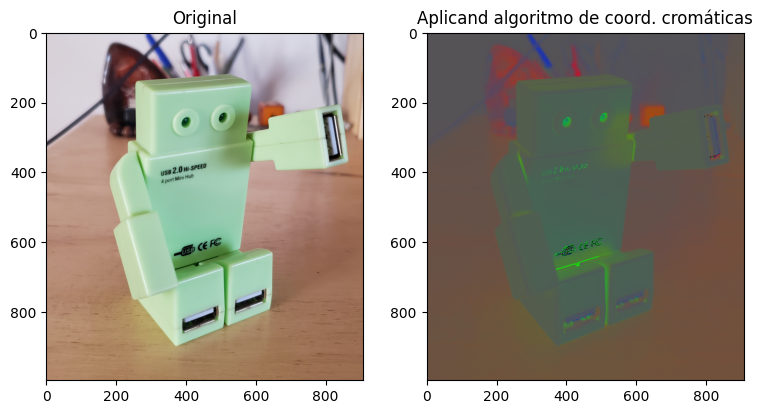

In [51]:
img = cv.imread('./coord_cromaticas/CoordCrom_1.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Nueva figura
fig = plt.figure(figsize=(9,6))

# Imagen original
ax1=plt.subplot(121)
ax1.imshow(img)
ax1.set_title('Original')

# Imagen luego de aplicar algoritmo de coordenadas cromáticas
ax1=plt.subplot(122)
img_new = coord_chromaticas(img)
ax1.imshow(img_new)
ax1.set_title('Aplicand algoritmo de coord. cromáticas')

2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.

In [ ]:
def white_patch(img):
    """ Función que implementa algoritmo de white patch."""

3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White
patch

Text(0.5, 1.0, 'Aplicand algoritmo de coord. cromáticas')

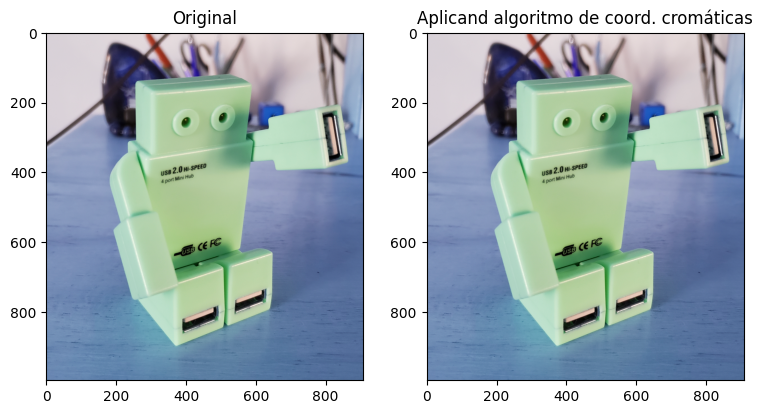

In [8]:
img = cv.imread('./coord_cromaticas/CoordCrom_1.png')

# Nueva figura
fig = plt.figure(figsize=(9,6))

# Imagen original
ax1=plt.subplot(121)
ax1.imshow(img)
ax1.set_title('Original')

# Imagen luego de aplicar algoritmo de coordenadas cromáticas
ax1=plt.subplot(122)
img_new = coord_chromaticas(img)
ax1.imshow(img_new)
ax1.set_title('Aplicand algoritmo de coord. cromáticas')